/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

2.12.0
2.12.0
11490434/11490434 [==============================] - 0s 0us/step


/tmp/ipykernel_32/2950650305.py:77: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=define_model,
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not lo

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
Epoch 1/10
Epoch 1/10
40/40 [==============================] - 2s 7ms/step - loss: 2.3029 - acc: 0.0463
Epoch 2/10
40/40 [==============================] - 2s 7ms/step - loss: 2.3029 - acc: 0.0833
Epoch 2/10
Epoch 2/10
40/40 [==============================] - 0s 6ms/step - loss: 2.3037 - acc: 0.0892
Epoch 3/10
40/40 [==============================] - 0s 6ms/step - loss: 2.3028 - acc: 0.0838
Epoch 3/10
40/40 [==============================] - 0s 5ms/step - loss: 2.3028 - acc: 0.0500
Epoch 4/10
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 2.3037 - acc: 0.0892
Epoch 5/10
40/40 [==============================] - 0s 6ms/step - loss: 2.3029 - acc: 0.0455
Epoch 5/10
40/40 [==============================] - 0s 11ms/step - loss: 2.3029 - acc: 0.1025
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 2.3037 - acc: 0.0878
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 2.3028 - acc: 0.0437
Epoch 6/10
22/40 [=======

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

40/40 [==============================] - 0s 8ms/step - loss: 2.2907 - acc: 0.2895
Epoch 3/10
40/40 [==============================] - 3s 10ms/step - loss: 2.2971 - acc: 0.1505
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 2.2578 - acc: 0.2780
Epoch 4/10
40/40 [==============================] - 3s 10ms/step - loss: 2.3011 - acc: 0.1135
Epoch 2/10
40/40 [==============================] - 0s 9ms/step - loss: 2.2618 - acc: 0.1785
Epoch 3/10
40/40 [==============================] - 0s 11ms/step - loss: 2.2757 - acc: 0.2873
Epoch 3/10
 1/40 [..............................] - ETA: 0s - loss: 1.9226 - acc: 0.4900

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

27/40 [===================>..........] - ETA: 0s - loss: 2.1382 - acc: 0.3200

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

40/40 [==============================] - 1s 13ms/step - loss: 2.0459 - acc: 0.3593
Epoch 4/10
40/40 [==============================] - 3s 12ms/step - loss: 2.2983 - acc: 0.1252
Epoch 2/10
40/40 [==============================] - 0s 11ms/step - loss: 1.7747 - acc: 0.5038
Epoch 6/10
40/40 [==============================] - 0s 9ms/step - loss: 2.2732 - acc: 0.2135
Epoch 4/10
16/40 [===========>..................] - ETA: 0s - loss: 0.7884 - acc: 0.7538

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

40/40 [==============================] - 0s 8ms/step - loss: 0.7290 - acc: 0.7705
Epoch 6/10
40/40 [==============================] - 0s 10ms/step - loss: 2.1921 - acc: 0.3590
Epoch 5/10
 1/40 [..............................] - ETA: 0s - loss: 2.1917 - acc: 0.3400

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so:

40/40 [==============================] - 0s 9ms/step - loss: 1.8617 - acc: 0.4425
Epoch 8/10
Epoch 6/10
40/40 [==============================] - 0s 10ms/step - loss: 0.5061 - acc: 0.8472
Epoch 8/10
40/40 [==============================] - 4s 14ms/step - loss: 2.2884 - acc: 0.1963
Epoch 2/10
Epoch 4/10
40/40 [==============================] - 1s 15ms/step - loss: 0.6238 - acc: 0.8090
Epoch 8/10
40/40 [==============================] - 0s 12ms/step - loss: 0.6249 - acc: 0.8142
Epoch 10/10
 6/40 [===>..........................] - ETA: 0s - loss: 0.7715 - acc: 0.7333Epoch 3/10
Epoch 5/10
40/40 [==============================] - 0s 10ms/step - loss: 0.4002 - acc: 0.8795
Epoch 10/10
40/40 [==============================] - 1s 13ms/step - loss: 0.7525 - acc: 0.7575
Epoch 6/10
40/40 [==============================] - 0s 10ms/step - loss: 1.2631 - acc: 0.5800
Epoch 4/10
40/40 [==============================] - 0s 11ms/step - loss: 0.5024 - acc: 0.8393
Epoch 6/10
40/40 [=========================

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 0s 10ms/step - loss: 0.3767 - acc: 0.8863
Epoch 1/10
40/40 [==============================] - 0s 10ms/step - loss: 1.5453 - acc: 0.5098
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 0.3425 - acc: 0.8940
Epoch 10/10
33/40 [=======================>......] - ETA: 0s - loss: 0.6914 - acc: 0.7752

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 0s 8ms/step - loss: 0.6686 - acc: 0.7850
Epoch 4/10
40/40 [==============================] - 0s 6ms/step - loss: 0.3105 - acc: 0.9050


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 0s 6ms/step - loss: 0.4737 - acc: 0.8500
Epoch 5/10
17/40 [===========>..................] - ETA: 0s - loss: 0.3752 - acc: 0.8847

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 0s 6ms/step - loss: 0.3823 - acc: 0.8815
Epoch 6/10
31/40 [======================>.......] - ETA: 0s - loss: 0.3022 - acc: 0.9090Epoch 1/10
Epoch 1/10
40/40 [==============================] - 0s 6ms/step - loss: 0.3055 - acc: 0.9062
Epoch 7/10
40/40 [==============================] - 0s 6ms/step - loss: 0.2830 - acc: 0.9125
Epoch 8/10
40/40 [==============================] - 0s 7ms/step - loss: 0.2417 - acc: 0.9255
Epoch 9/10
40/40 [==============================] - 0s 6ms/step - loss: 1.4256 - acc: 0.5355
Epoch 3/10
40/40 [==============================] - 0s 7ms/step - loss: 0.6695 - acc: 0.7812
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 1.5719 - acc: 0.4955
Epoch 3/10
40/40 [==============================] - 3s 11ms/step - loss: 2.1250 - acc: 0.2465
Epoch 2/10
40/40 [==============================] - 0s 9ms/step - loss: 0.4003 - acc: 0.8808
Epoch 6/10
40/40 [==============================] - 0s 10ms/step - loss: 0

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


60/60 [==============================] - 1s 3ms/step - loss: 1.7654 - acc: 0.4035
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.5259 - acc: 0.8360
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.3405 - acc: 0.8917
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2596 - acc: 0.9172
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1932 - acc: 0.9373
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1667 - acc: 0.9452
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1352 - acc: 0.9550
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1244 - acc: 0.9627
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1026 - acc: 0.9668
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1045 - acc: 0.9658
Best: 0.927000 using {'learning_rate': 0.1, 'momentum': 0.9}
Mean = 0.083333 (st

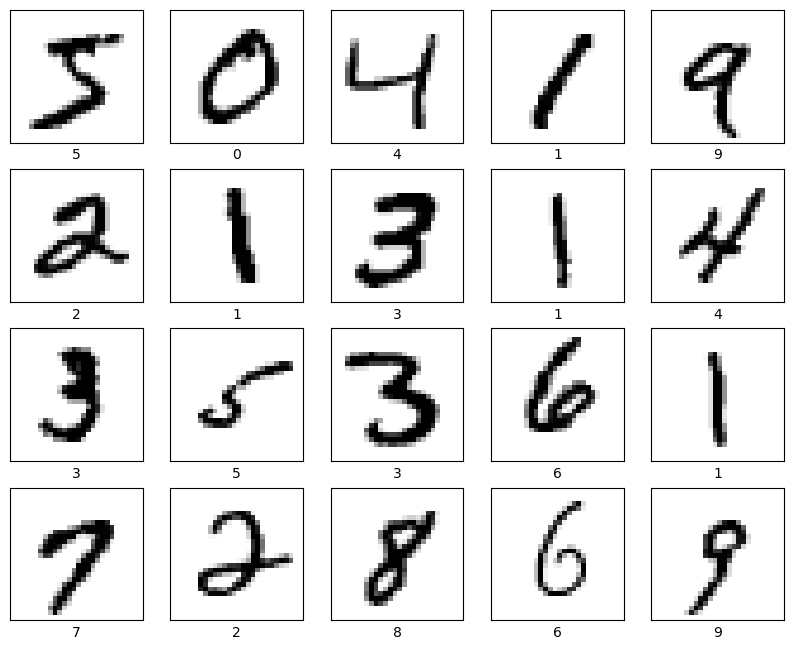

In [1]:

import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout

#from keras.callbacks import LearningRateScheduler

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

print(tf.__version__)
print(keras.__version__)

# fix random seed for reproducibility
np.random.seed(42)

mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])


# normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# reshape images to 1D so we can just work with dense layers
#For this demo purposes
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

num_classes = 10

# One hot encoding for categorical labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Take a subset of train for grid search. Let us take 10% for now
from sklearn.model_selection import train_test_split
x_grid, x_not_use, y_grid, y_not_use = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

# build the model
input_dim = x_grid.shape[1]


from keras.optimizers import SGD
#NOTE: Add default optimizer, otherwise throws error 'optimizer not legal parameter'
def define_model(learning_rate=0.01, momentum=0.1):   
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer='uniform', 
                    input_dim = input_dim)) 
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='uniform', activation='softmax'))
    optimizer = SGD(lr=learning_rate, momentum=momentum)
    # compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,      
                  metrics=['acc'])
    return model

# implement the Scikit-Learn classifier interface
# requires model defined as a function, which we already have
from keras.wrappers.scikit_learn import KerasClassifier
batch_size = 100
epochs = 10

model = KerasClassifier(build_fn=define_model, 
                        epochs=epochs, 
                        batch_size = batch_size, 
                        verbose=1)

learning_rate = [0.0001, 0.001, 0.01, 0.1]
momentum = [0.3, 0.5, 0.7, 0.9]

#n_jobs=16 uses 16 CPUs. Try not to do -1 on your system as it may hang!!!
# -1 refers to using all available CPUs
#Cross validation, cv=3
param_grid = dict(learning_rate=learning_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=16, cv=3)

grid_result = grid.fit(x_grid, y_grid)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))